# Step 3: Train and evaluate the Calorimetric method

In [1]:
distances = [15, 35]
doubleplanes = [8, 12, 20, 30]
energies = [200, 600, 1000]
erels = [100, 500, 1000, 2000, 3000]
neutrons = [1, 2, 3, 4, 5, 6]
physicss = ["bert", "bic", "inclxx"]

## a) Train calorimetric method for all settings

In [2]:
import os
import wurlitzer
import joblib
from helpers import filename_for
import ROOT

Welcome to JupyROOT 6.16/00


In [3]:
ROOT.ROOT.EnableThreadSafety()
ROOT.FairLogger.GetLogger().SetLogVerbosityLevel("LOW")
ROOT.FairLogger.GetLogger().SetLogScreenLevel("WARNING")
ROOT.gROOT.SetBatch(True)

In [4]:
def calibr(doubleplane, energy, nmax, physics):
    outfile = f"output/{physics}/{doubleplane}dp_{energy}AMeV_{nmax}n.ncut.root"
    logfile = f"output/{physics}/{doubleplane}dp_{energy}AMeV_{nmax}n.ncut.log"
    datfile = f"output/{physics}/{doubleplane}dp_{energy}AMeV_{nmax}n.ncut.dat"
    pdffile = f"results/multiplicity/cuts_{doubleplane}dp_{energy}AMeV_{nmax}n.pdf"

    if os.path.exists(outfile):
        os.remove(outfile)

    # Write all output to a log file
    with open(logfile, "w") as log, wurlitzer.pipes(stdout=log, stderr=wurlitzer.STDOUT):
        cal = ROOT.Neuland.Neutron2DCalibr(nmax)
        for neutron in range(1, nmax + 1):
            # Note: Calorimetric method should be more or less independent of distance and erel
            for distance in distances:
                for erel in erels:
                    digifile = filename_for(distance, doubleplane, energy, erel, neutron, physics, ".digi.root")
                    cal.AddClusterFile(digifile)

        # Starting parameters (double val, double step, double lower, double upper)
        vslope = ROOT.std.vector("double")()
        vslope += [0.04, 0.01, 0.01, 1]
        vdistance = ROOT.std.vector("double")()
        vdistance += [10, 1, 5, 25]
        vdist_off = ROOT.std.vector("double")()
        vdist_off += [3, 1, 0, 5]

        # Create Cuts
        cal.Optimize(vslope, vdistance, vdist_off)

        # Write the output files (root, dat, pdf)
        cal.WriteParameterFile(outfile)
        o = ROOT.std.ofstream(datfile)
        cal.Print(o)
        cal.Draw(pdffile)
        del cal

In [5]:
joblib.Parallel(n_jobs=-1, backend="multiprocessing", verbose=1)(
    joblib.delayed(calibr)(doubleplane=doubleplane, energy=energy, nmax=neutron, physics="inclxx")
    for energy in energies
    for doubleplane in doubleplanes
    for neutron in neutrons
)

print("Done")

[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 56 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 out of  72 | elapsed:   57.5s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:  5.2min finished


Done


## b) Apply cuts to a setting and evaluate performance

In [6]:
import numpy as np
import pandas as pd
from sklearn.metrics import (
    balanced_accuracy_score,
    confusion_matrix,
    plot_confusion_matrix,
)
import shutil
import subprocess

For each event, apply the cuts and list the predicted multiplicity along with the number of incoming neutrons, the number of primary points, etc.

In [7]:
def neuland_calorimetric_data(distance, doubleplane, energy, erel, nmax, physics):
    ncutfile = f"output/{physics}/{doubleplane}dp_{energy}AMeV_{nmax}n.ncut.root"
    file = ROOT.TFile.Open(ncutfile)
    para = file.Get("R3BNeulandNeutron2DPar")

    data = []
    num_ex = 0
    for neutron in range(1, nmax + 1):
        digifile = filename_for(distance, doubleplane, energy, erel, neutron, physics, ".digi.root")
        tfile = ROOT.TFile.Open(digifile)
        ttree = tfile.Get("evt")
        for event in ttree:
            # nPN: Number of incoming primary neutrons
            nIn = neutron
            # nPP: Number of primary neutrons with an energy deposition in NeuLAND
            nPP = event.NeulandPrimaryPoints.GetEntries()
            # nPH: Number of hits that correspond to a energy deposition of a primary neutron
            nPH = event.NeulandPrimaryHits.GetEntries()
            # nHits: Number of hits
            num_hits = event.NeulandHits.GetEntries()
            # nClus: Number of clusters
            num_clusters = event.NeulandClusters.GetEntries()
            # Edep: Total deposited (detected) energy
            try:
                edep = round(sum([hit.GetE() for hit in event.NeulandHits]))
            except:
                num_ex += 1
                edep = 0

            # Use calibrated calorimetric method (R3BNeulandNeutron2DPar) from the parameter file
            # to predict the multiplicity
            mult = para.GetNeutronMultiplicity(edep, num_clusters)

            data.append([nIn, nPP, nPH, num_hits, num_clusters, edep, mult])
    datapd = pd.DataFrame(data)
    datapd.columns = ["nIn", "nPP", "nPH", "num_hits", "num_cluster", "edep", "mult"]
    return datapd

In [8]:
distance = 15
doubleplane = 30
erel = 500
nmax = 5
physics = "inclxx"

data = {
    energy: neuland_calorimetric_data(distance, doubleplane, energy, erel, nmax, physics) for energy in [200, 600, 1000]
}

pd.options.display.max_rows = 20
display(data[600])

,nIn,nPP,nPH,num_hits,num_cluster,edep,mult
0,1,1,1,8,2,203,1
1,1,1,1,12,1,320,1
2,1,1,1,13,6,287,1
3,1,1,1,12,5,317,1
4,1,1,1,14,8,287,1
...,...,...,...,...,...,...,...
49995,5,5,5,29,17,693,3
49996,5,5,5,68,13,981,3
49997,5,4,4,46,25,771,4
49998,5,5,5,67,29,991,4


Example neutron separation matrices and balanced accuracy score

In [9]:
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

out = []
for energy, df in data.items():
    print(energy)
    y_true = df[["nIn"]].values.ravel()
    y_pred = df[["mult"]].values.ravel()

    bac = balanced_accuracy_score(y_true, y_pred)
    print(bac)
    # cm = confusion_matrix(y_true, y_pred, labels=range(0, 6))
    # print(np.swapaxes(cm, 0, 1))
    cmrel = confusion_matrix(y_true, y_pred, labels=range(0, 6), normalize="true")
    cmrel = np.swapaxes(cmrel, 0, 1)
    print(cmrel)
    out.append([energy, bac, cmrel])

200
0.60646
[[0.    0.148 0.013 0.001 0.    0.   ]
 [0.    0.798 0.232 0.039 0.005 0.001]
 [0.    0.053 0.633 0.274 0.064 0.012]
 [0.    0.    0.121 0.536 0.295 0.091]
 [0.    0.    0.    0.148 0.475 0.306]
 [0.    0.    0.    0.002 0.162 0.59 ]]
600
0.63106
[[0.    0.087 0.007 0.001 0.    0.   ]
 [0.    0.811 0.163 0.02  0.003 0.   ]
 [0.    0.102 0.679 0.24  0.048 0.007]
 [0.    0.    0.151 0.585 0.3   0.084]
 [0.    0.    0.001 0.151 0.515 0.343]
 [0.    0.    0.    0.003 0.135 0.566]]
1000


/home/jmayer/.pyenv/versions/3.7.6/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


0.6101000000000001
[[0.    0.076 0.006 0.    0.    0.   ]
 [0.    0.811 0.173 0.021 0.002 0.   ]
 [0.    0.104 0.693 0.268 0.056 0.009]
 [0.    0.003 0.119 0.589 0.359 0.106]
 [0.    0.003 0.005 0.114 0.481 0.409]
 [0.    0.003 0.005 0.009 0.102 0.476]]


## c) Create a Latex file with the multiplicity matrices

In [10]:
def to_tabular(energy, bac, cm, nmax):
    text = ""
    text += "\\resizebox{0.32\\textwidth}{!}{\n"
    text += "\\begin{tabular}{cc|" + "S[table-format=2]" * nmax + "}\n"
    text += "\\toprule\n"
    text += "\\multicolumn{2}{c|}{" + str(energy) + "} & \\multicolumn{" + str(nmax) + "}{c}{generated} \\\\\n"
    text += "\\multicolumn{2}{c|}{MeV} &" + " & ".join([str(n) for n in range(1, nmax + 1)]) + " \\\\\n"
    text += "\\midrule\n"
    text += "\\multirow{" + str(nmax + 1) + "}{*}{\\rotatebox[origin=c]{90}{detected}}\n"

    for i, a in enumerate(cm[: nmax + 1]):
        text += " & " + str(i)
        for j, x in enumerate(a[1 : nmax + 1]):
            if j == i - 1:
                text += " & \\textbf{" + str(int(round(x * 100))) + "}"
            else:
                text += " & " + str(int(round(x * 100)))
        text += " \\\\\n"

    text += "\\bottomrule\n"
    text += "\\end{tabular}}"
    return text

In [11]:
def to_full_latex(data, distance, doubleplane, energy, erel, nmax, physics):
    text = """\\documentclass{{scrartcl}}
\\usepackage{booktabs}
\\usepackage{siunitx}
\\usepackage{multirow}
\\usepackage{graphicx}
\\begin{document}
\\begin{table}
"""
    text += f"""\\captionabove[Neutron separation matrices for multiplicities of 1 to {nmax} neutrons]{{
Neutron separation matrices for multiplicities of 1 to {nmax} neutrons.
Columns display the neutron multiplicity simulated, rows the neutron multiplicity derived from the calorimetric algorithm.
Values are given in percent.
Neutrons were simulated with 200 (left), 600 (center) and 1000 MeV (right matrix).
NeuLAND with {doubleplane} doubleplanes was located at a distance of {distance} m to the target.
Neutrons were generated with a relative energy of {erel} keV with respect to a medium heavy projectile fragment.
The distance between target and NeuLAND was filled with air and a 4\\,mm steel window.
Simulated with Geant4 using the \\texttt{{QGSP\\_{physics.upper()}\\_HP}} physics list.
Note that other maximum multiplicities will result in different efficiencies.
\\label{{tab:neutron-separation-matrices}}}}
"""
    for o in data:
        text += to_tabular(*o, nmax) + "\n"
    text += """\\end{table}
\\end{document}
"""
    return text

In [40]:
distance = 15
erel = 500
physics = "inclxx"

results = []
for doubleplane in doubleplanes:
    for nmax in neutrons:
        data = {
            energy: neuland_calorimetric_data(distance, doubleplane, energy, erel, nmax, physics) for energy in energies
        }

        out = []
        for energy, df in data.items():
            y_true = df[["nIn"]].values.ravel()
            y_pred = df[["mult"]].values.ravel()

            bac = balanced_accuracy_score(y_true, y_pred)
            cmrel = confusion_matrix(y_true, y_pred, labels=range(0, nmax + 1), normalize="true")
            cmrel = np.swapaxes(cmrel, 0, 1)
            out.append([energy, bac, cmrel])
            results.append((doubleplane, energy, nmax, bac, cmrel[nmax][nmax]))

        fpath = "results/multiplicity/"
        fbase = f"calorimetric-{doubleplane:02d}dp-{nmax}n"
        with open(fpath + fbase + ".tex", "w") as f:
            latex = to_full_latex(out, distance, doubleplane, energy, erel, nmax, physics)
            f.write(latex)
        subprocess.call(["lualatex", fbase + ".tex"], cwd=fpath, stdout=subprocess.DEVNULL)
        os.remove(fpath + fbase + ".aux")
        os.remove(fpath + fbase + ".log")

/home/jmayer/.pyenv/versions/3.7.6/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/home/jmayer/.pyenv/versions/3.7.6/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/home/jmayer/.pyenv/versions/3.7.6/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/home/jmayer/.pyenv/versions/3.7.6/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/home/jmayer/.pyenv/versions/3.7.6/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1814: UserWarning: y_pred contains classes not in y_tr

In [43]:
pd.options.display.max_rows = 100
resultsdf = pd.DataFrame(results)
resultsdf.columns = ["doubleplane", "energy", "nmax", "bac", "eff"]
display(resultsdf)

,doubleplane,energy,nmax,bac,eff
0,8,200,1,0.425300,0.4253
1,8,600,1,0.522000,0.5220
2,8,1000,1,0.590100,0.5901
3,8,200,2,0.308050,0.1783
4,8,600,2,0.382800,0.4211
5,8,1000,2,0.416450,0.5515
6,8,200,3,0.266533,0.2549
7,8,600,3,0.316700,0.3115
8,8,1000,3,0.334033,0.3492
9,8,200,4,0.234125,0.2335


Using matplotlib backend: agg


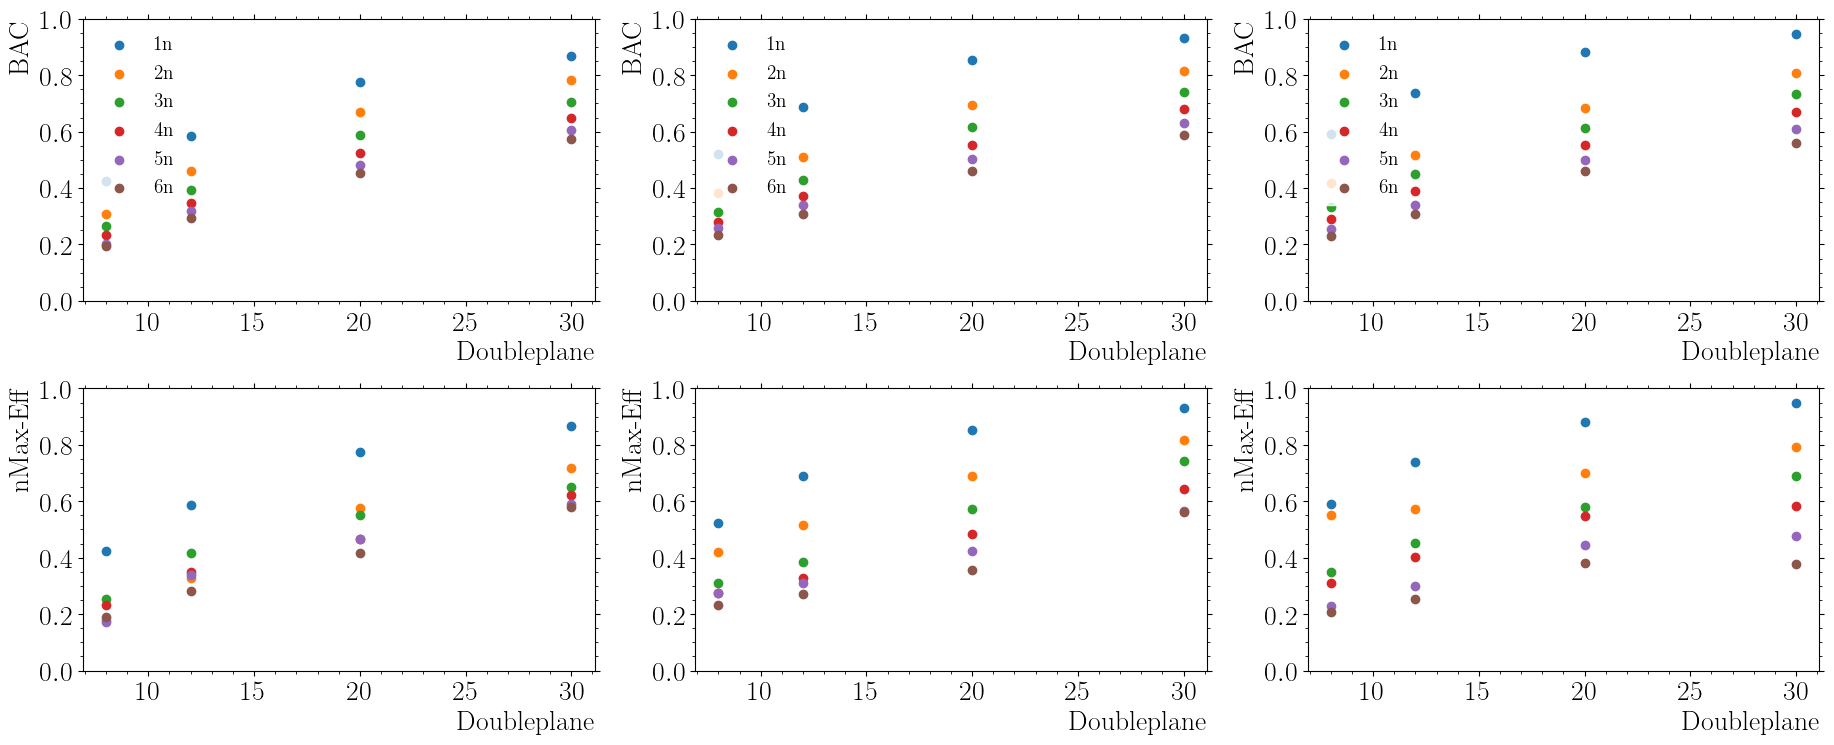

In [42]:
%matplotlib

from plotconfroot import *

fig = plt.figure(figsize=(6.224 * 3, 6.224 / 1.618 * 2))
for i, energy in enumerate(energies):
    ax = fig.add_subplot(2, 3, i + 1)
    ax.set_xlabel(r"Doubleplane", horizontalalignment="right", x=1)
    ax.set_ylim(0, 1)
    ax.set_ylabel(r"BAC", horizontalalignment="right", y=1)

    ax2 = fig.add_subplot(2, 3, 3 + i + 1)
    ax2.set_xlabel(r"Doubleplane", horizontalalignment="right", x=1)
    ax2.set_ylim(0, 1)
    ax2.set_ylabel(r"nMax-Eff", horizontalalignment="right", y=1)
    
    for nmax in neutrons:
        tmp = resultsdf.loc[(resultsdf["energy"] == energy) & (resultsdf["nmax"] == nmax)]
        ax.scatter(
            tmp["doubleplane"].values, tmp["bac"].values, label=f"{nmax}n",
        )
        ax2.scatter(
            tmp["doubleplane"].values, tmp["eff"].values, label=f"{nmax}n",
        )   
     
    ax.legend(loc="upper left", prop={"size": "x-small"})
fig.savefig("results/calibr-bac-dp.pdf", bbox_inches="tight")
fig.tight_layout()
display(fig)